In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

data = pd.read_csv("data/dataset.csv")


feature_list = [
    item for item in Path("features_list.txt").read_text().split("\n") if item
]

In [2]:
data.drop(data.loc[data["def_45"].isna()].index, inplace=True)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re


class Preprocessor:
    feature_list: list[str]
    column_transformer: ColumnTransformer
    exclude_cols: list[str]
    categorized_columns: dict[str, list[str]]

    def __init__(self, feature_list: list[str], exclude_cols: list[str]) -> None:
        self.feature_list = feature_list
        self.exclude_cols = exclude_cols

    def _init_transformer_params(self) -> None:
        self.transformer_params = {
            "transformers": [
                ("cats", OrdinalEncoder(), self.categorized_columns.get("categorical")),
                (
                    "numscaler",
                    StandardScaler(),
                    self.categorized_columns.get("numeric"),
                ),
            ],
            "remainder": "passthrough",
            "verbose": True,
        }

    def _train_transformer(self, data: pd.DataFrame) -> None:
        self._init_transformer_params()
        self.column_transformer = ColumnTransformer(**self.transformer_params)
        self.column_transformer.fit(data)

    def _categorize_columns(self, data: pd.DataFrame) -> None:
        numeric_cols = []
        boolean_cols = []
        categorical_cols = []

        for col in data.columns:
            # Булевые (bool или содержат только 0/1, True/False)
            if data[col].dtype == "bool":
                boolean_cols.append(col)
            # Числовые (int, float)
            elif pd.api.types.is_numeric_dtype(data[col]):
                # Проверяем, не является ли числовая колонка на самом деле булевой
                unique_vals = data[col].dropna().unique()
                if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                    boolean_cols.append(col)
                else:
                    numeric_cols.append(col)
            # Категориальные (object, category, datetime)
            else:
                categorical_cols.append(col)

        self.categorized_columns = {
            "numeric": numeric_cols,
            "boolean": boolean_cols,
            "categorical": categorical_cols,
        }

    @staticmethod
    def _remove_duplicates(data: pd.DataFrame) -> pd.DataFrame:
        return data.drop_duplicates()

    @staticmethod
    def _fill_missing_values(
        data: pd.DataFrame, num_cols: list[str], cat_cols: list[str]
    ) -> pd.DataFrame:
        data = data.copy()

        for col in num_cols:
            if data[col].isna().any():
                data[col].fillna(data[col].mean(), inplace=True)

        for col in cat_cols:
            if data[col].isna().any():
                mode_value = data[col].mode()
                if not mode_value.empty:
                    data[col].fillna(mode_value.iloc[0], inplace=True)

        return data

    @staticmethod
    def _remove_prefixes(columns: list[str]) -> list[str]:
        pattern = r"^(cats__|numscaler__|remainder__)"
        return [re.sub(pattern, "", col) for col in columns]

    def transform_data(self, data: pd.DataFrame) -> pd.DataFrame:
        step_0 = data[self.feature_list].copy()

        # Сохраняем excluded колонки ДО обработки
        excluded_data = step_0[self.exclude_cols].copy()

        self._categorize_columns(step_0.drop(columns=self.exclude_cols))

        step_1 = self._remove_duplicates(step_0.drop(columns=self.exclude_cols))

        # Сохраняем индексы после удаления дубликатов
        valid_indices = step_1.index

        step_2 = self._fill_missing_values(
            step_1,
            self.categorized_columns.get("numeric"),
            self.categorized_columns.get("categorical"),
        )

        # Добавляем excluded колонки ТОЛЬКО для сохранившихся индексов
        for col in self.exclude_cols:
            step_2[col] = excluded_data.loc[valid_indices, col].values

        self._train_transformer(step_2)

        step_3_array = self.column_transformer.transform(step_2)
        step_3 = pd.DataFrame(
            step_3_array,
            columns=self._remove_prefixes(
                self.column_transformer.get_feature_names_out()
            ),
        )

        return step_3

In [4]:
train_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

test_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

valid_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

In [5]:
from utils import split_data


train_valid, test = split_data(data, split_column="application_datetime", ratio=0.8)


train, valid = split_data(train_valid, split_column="application_datetime", ratio=0.8)

del train_valid

In [6]:
train = train_preprocessor.transform_data(train)
test = test_preprocessor.transform_data(test)
valid = valid_preprocessor.transform_data(valid)

[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


/tmp/ipykernel_143137/3575576222.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipykernel_143137/3575576222.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import get_scorer_names, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool

cat_features = train_preprocessor.categorized_columns.get("categorical")
train_target = train.pop("def_45")
valid_target = valid.pop("def_45")
test_target = test.pop("def_45")


train_pool = Pool(
    train.drop(columns=["application_datetime"]),
    label=train_target,
    cat_features=cat_features,
)

valid_pool = Pool(
    valid.drop(columns=["application_datetime"]),
    label=valid_target,
    cat_features=cat_features,
)

test_pool = Pool(
    test.drop(columns=["application_datetime"]),
    label=test_target,
    cat_features=cat_features,
)

In [8]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    auto_class_weights="Balanced",
    early_stopping_rounds=50,
    eval_metric="AUC",
    verbose=100,
)

model.fit(train_pool)

0:	total: 48.7ms	remaining: 48.7s
100:	total: 200ms	remaining: 1.78s
200:	total: 349ms	remaining: 1.39s
300:	total: 495ms	remaining: 1.15s
400:	total: 654ms	remaining: 976ms
500:	total: 826ms	remaining: 823ms
600:	total: 971ms	remaining: 645ms
700:	total: 1.12s	remaining: 478ms
800:	total: 1.28s	remaining: 319ms
900:	total: 1.43s	remaining: 157ms
999:	total: 1.57s	remaining: 0us


In [9]:
p_v = model.predict(valid_pool)
print("ROC AUC: ", roc_auc_score(valid_target.to_list(), p_v))

ROC AUC:  0.9818424137799893


In [10]:
p_t = model.predict(test_pool)
print("ROC AUC: ", roc_auc_score(test_target.to_list(), p_t))

ROC AUC:  0.9900197628458498


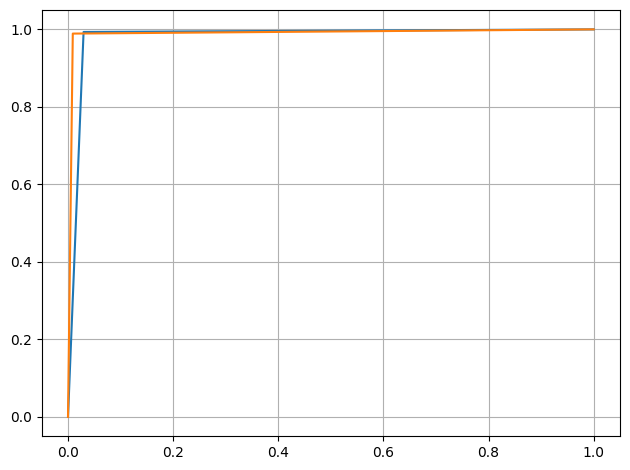

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.Figure()

valid_curve = roc_curve(valid_target.to_list(), p_v)

test_curve = roc_curve(test_target.to_list(), p_t)


sns.lineplot(x=valid_curve[0], y=valid_curve[1])
sns.lineplot(
    x=test_curve[0],
    y=test_curve[1],
)
sns.color_palette("pastel")


plt.tight_layout()
plt.grid()

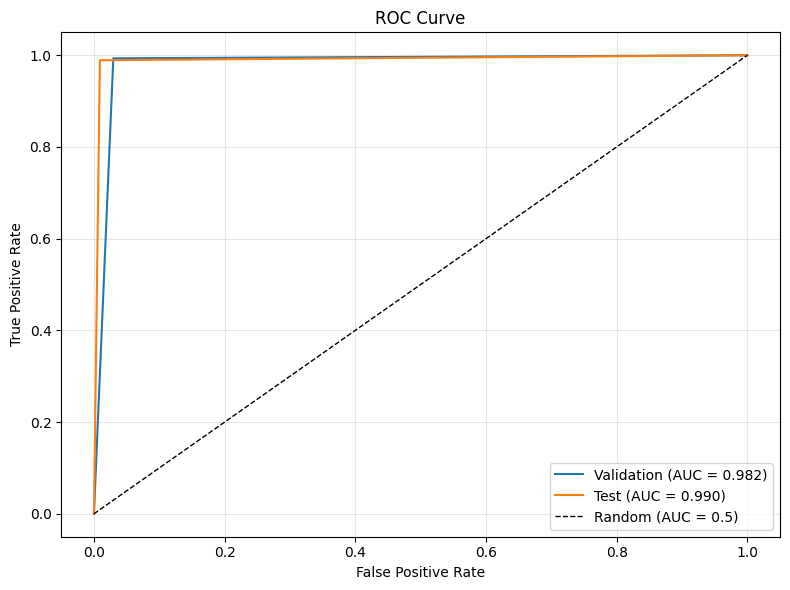

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Правильная инициализация фигуры
fig, ax = plt.subplots(figsize=(8, 6))

# Вычисляем ROC кривые
valid_fpr, valid_tpr, _ = roc_curve(valid_target.to_list(), p_v)
test_fpr, test_tpr, _ = roc_curve(test_target.to_list(), p_t)

# Вычисляем AUC для отображения в легенде
valid_auc = auc(valid_fpr, valid_tpr)
test_auc = auc(test_fpr, test_tpr)

# Устанавливаем палитру
sns.set_palette("pastel")

sns.lineplot(
    x=valid_fpr, y=valid_tpr, label=f"Validation (AUC = {valid_auc:.3f})", ax=ax
)
sns.lineplot(x=test_fpr, y=test_tpr, label=f"Test (AUC = {test_auc:.3f})", ax=ax)

# Добавляем диагональную линию (случайный классификатор)
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC = 0.5)")

# Настройки графика
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Обучение модели, валидация
Как валидировать? Как тестировать? В чём отличие?)

Ответ: Валидационная выборка нужна для того, чтобы отслеживать стабильность в обучении модели во время подбора гиперпараметров и тестирования. Тестовая выборка нужна для итоговой оценки качества модели на новых данных.

Фукнции валидации:
- Отслеживание переобучения
- Выбор оптимальных гиперпараметров
- Сравнение разных архитектур моделей

Функции тестовой выборки:
- Объективная оценка производительности на "невиденных" данных
- Оценка способности модели к генерализации